# Init

In [1043]:
import datetime
import numpy as np
import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

# Read the data

In [1044]:
df = pd.read_csv(
    "../data/train_data_cleaned.csv",
    # Note: some of the variables should be treated as 
    dtype={"year_week": str, "recipe_id": str},
)
df.head()

,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,description,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales
0,201801,14919,Shrimp & Broccol...,2 person,687.0,99.2,time_level_4,asian,"For this dish, o...",easy,fish,optional_heat,18.6,No,7,shellfish,rice,"fish_and_side,st...",all_seasons,shellfish,29.5,main,NaN,healthy_choice,0.0,NaN,3567
1,201801,14920,Caramelized Cabb...,2 person,779.0,81.3,time_level_4,new_american,Red lentil penne...,easy,veggie,no_heat,38.5,No,5,no_protein,pasta_incl_gnocc...,pasta,all_seasons,no_protein,30.0,main,NaN,quick,0.0,no_cut,2532
2,201801,14449,AFC Vegetarian P...,z_amazon,642.0,92.8,NaN,NaN,Pad Thai is one ...,easy,veggie,NaN,25.6,No,10,NaN,NaN,NaN,NaN,NaN,16.2,NaN,NaN,NaN,NaN,NaN,6
3,201801,11963,Shrimp & Broccol...,family,620.0,93.2,time_level_4,asian,"For this dish, o...",easy,fish,optional_heat,13.7,No,7,shellfish,rice,"fish_and_side,st...",all_seasons,shellfish,28.7,main,NaN,healthy_choice,0.0,NaN,642
4,201801,14914,Chicken & Pasta ...,family,610.0,67.0,time_level_4,new_american,We've never met ...,easy,meat,no_heat,20.0,No,7,poultry,"sweet_potato,pas...",soup,all_seasons,poultry,36.0,main,NaN,healthy_choice,0.0,breast,1492


In [1046]:
df["recipe_name_clean"] = (df
    .recipe_name
    .apply(lambda text: text.lower().strip())
    # Based on the analysis, it can make sense to matches these cases
    .replace({
        "chile-lime fish tacos": "chili-lime fish tacos",
        "spicy shrimp noodles": "spicy shrimp ramen",
        "grilled berkshire pork": "grilled pork wraps",
        "spiced berkshire pork": "spiced pork tenderloin steaks",
        "moroccan pork tenderloin": "moroccan-spiced berkshire pork",
        "orecchiette and sausage": "orecchiette & sausage",
    })
)

# Functions

In [1048]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [1049]:
def clean_data(df):
    df["week_day"] = df.year_week.apply(
        lambda year_week: datetime.datetime.strptime(year_week + '-1', "%G%V-%u")
    )
    df["close_to_new_year"] = df.year_week.str.endswith(("01", "02", "52", "51", "50")).astype(int)
    df["n_words"] = df.description.fillna("").str.len()
    df["month"] = df.week_day.dt.month
    df["week"] = np.cos(df.year_week.str.slice(4, 6).astype(int) / 13 * 2 * np.pi)
    df = df.merge(
        (df
         .groupby("year_week")
         .agg({"recipe_id": "count", "sales": "sum"})
         .rename(columns={"recipe_id": "count", "sales": "total_sales"})),
        how="left",
        left_on="year_week",
        right_index=True,
    )
#     df_stats = df.sort_values("year_week").groupby(["recipe_name_clean", "product_type"]).cumcount()
    df_stats = df.sort_values("proteins", ascending=False).groupby(["year_week"]).calories.rank()
    df_stats.name = "cumcount"
    df = df.merge(df_stats, how="left", left_index=True, right_index=True)
    return df

# Train/validation split

In [1123]:
date_start = "201936"
date_end = "201944"

# date_start = "201928"
# date_end = "201936"

# date_start = "201920"
# date_end = "201928"

df_clean = clean_data(df.copy())
df_train = df_clean[df_clean.year_week <= date_start]
print(df_train.shape)

df_validation = df_clean[(df_clean.year_week > date_start) & (df_clean.year_week <= date_end)]
print(df_validation.shape)

assert len(df_validation.year_week.unique()) == 8, len(df_validation.year_week.unique())

(2611, 36)
(328, 36)


# Baseline model - constant average prediction

In [1124]:
rmse(df_validation.sales, [df_train["sales"].mean()] * len(df_validation))

3782.4649535100893

In [1125]:
year_weeks = sorted(df_train.year_week.unique())
df_train_subset = df_train[df_train.year_week.isin(year_weeks[-8:])]
rmse(df_validation.sales, [df_train_subset["sales"].mean()] * len(df_validation))

3705.2563002051347

# Main model

In [1128]:
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from category_encoders.ordinal import OrdinalEncoder

categorical_features = [
    'product_type',
    'course_type',
    'dish_type',
    'protein_cuts',
    'heat_level',
#     "protein_cuts",
#     "recipe_name_clean",
    
#     'preferences',
#     'cooking_time',
#     'seasons
]
numerical_features = [
    "proteins",
    "number_of_ingredients_per_recipe",
    "fat",
    "carbs",
    "calories",
#     "count",
#     "cumcount",
#     "n_words",
#     "close_to_new_year",
]
text_features = [
    "recipe_name_clean",
    "protein_types",
    "meta_tags",
    "carbs_content",
#     "cuisine",
    "dish_types",
#     "seasons",',
#     "cuisine",
#     "description",
]

product_type = "2 person"
df_train_cleaned = df_train#[df_train.product_type == product_type]
df_val_cleaned = df_validation#[df_validation.product_type == product_type]

# Note: tree will work faster with ordinal encoded feature, but one hot encoded features
# make it easier to transition from models based on the numerical features to the models based
# on the decision trees. Since there is quite little data it's much more efficient to use
# one encoder for all of the experiments.
# encoder = OneHotEncoder(handle_unknown="ignore")
encoder = OrdinalEncoder(handle_unknown="ignore")
X_train = encoder.fit_transform(df_train_cleaned[categorical_features].fillna("UNK").astype(str))
X_train = np.hstack((X_train, df_train_cleaned[numerical_features]))
y_train = df_train_cleaned["sales"]

X_val = encoder.transform(df_val_cleaned[categorical_features].fillna("UNK").astype(str))
X_val = np.hstack((X_val, df_val_cleaned[numerical_features]))
y_val = df_val_cleaned["sales"]

for text_feature in text_features:
    if text_feature == "description":
        name_vectorizer = TfidfVectorizer(min_df=100, stop_words="english")
    else:
        name_vectorizer = TfidfVectorizer(min_df=50, stop_words="english")
    X_train_name = name_vectorizer.fit_transform(df_train_cleaned[text_feature].fillna("").replace(",", " "))
    X_val_name = name_vectorizer.transform(df_val_cleaned[text_feature].fillna("").replace(",", " "))

    X_train = sparse.hstack([X_train, X_train_name])
    X_val = sparse.hstack([X_val, X_val_name])
    
# X_train = sparse.hstack([X_train, np.array(vectors_desc_train)])
# X_val = sparse.hstack([X_val, np.array(vectors_desc_val)])

print(X_train.shape)
print(X_val.shape)

(2611, 94)
(328, 94)


In [1129]:
import lightgbm
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# model = RandomForestRegressor(n_estimators=200, min_samples_leaf=10)#, max_features=100)
# model = DecisionTreeRegressor(min_samples_leaf=100)
# model = SVR()

model = lightgbm.LGBMRegressor(
    n_estimators=300,
    num_leaves=7,
    max_depth=3,
    objective="mse",
    learning_rate=0.02,
    colsample_bytree=0.6,
    verbosity=-1,
    extra_trees=True,
#     bagging_freq=10,
#     path_smooth=0.1,
#     reg_lambda=1000,
)

model.fit(
    X_train,
    y_train,
    # Note: sample_weight helps to add more importance to the most recent obsevations
    sample_weight=((df_train_cleaned.week_day - df_train_cleaned.week_day.min()).dt.days + 1) ** 6,
)
y_predicted = np.clip(model.predict(X_val), 0, np.inf)
rmse(y_val, y_predicted)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:597: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


2820.0904520799672

In [986]:
# from sklearn.neural_network import MLPRegressor
# model2 = MLPRegressor((300, 50), verbose=True, max_iter=200)
# model2.fit(X_train, y_train)
# y_predicted = model2.predict(X_val)
# print(rmse(y_val, y_predicted))

In [987]:
model.feature_importances_[:len(encoder.get_feature_names())]

array([128,  48,  51,  11], dtype=int32)

In [988]:
model.feature_importances_[len(encoder.get_feature_names()):]

array([ 43,  23,  33,  30,  35,  80,   0,   0,   4,   0,   0,   2,   3,
         2,   0,  88,   0,  36,   0,   5,   4,  65,  28,  19,   1,   9,
        64,   1,   3,  45,  16,   1,   7,   0,   0,  26,   1,  31,   0,
         4,   0,   0, 148,   0,   2,   0,   0,   0,   7,   0,   2,   0,
         9,  59,  10,   0,   3,   0,   0,  12,  28,   0,  71,  43,  76,
         2,   6,  20,  25,  16,  66,  53,   4,   1,   1,   2,   1,  15,
         2,   0,  48], dtype=int32)

In [1080]:
df_validation["sales_predicted"] = y_predicted
df_validation["diff"] = (y_predicted - y_val).abs()
df_validation.sort_values("diff")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,description,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,close_to_new_year,n_words,month,week,count,total_sales,cumcount,sales_predicted,diff
2903,201944,38232,Veggie Grain Bowl,family,740.0,85.0,time_level_4,NaN,Good-for-you foo...,easy,veggie,no_heat,40.0,No,9,dairy,rice,salad,NaN,dairy,18.0,main,NaN,"quick,healthy_ch...",0.0,NaN,126,veggie grain bowl,2019-10-28,0,406,10,-0.748511,40,80493,14.5,121.983072,4.016928
2616,201937,35957,Red Curry Tofu &...,family,540.0,51.0,time_level_5,asian_fusion,"Red curry paste,...",easy,veggie,no_heat,24.0,No,9,tofu_or_similar,rice_noodles,noodle,NaN,tofu_or_similar,32.0,main,NaN,healthy_choice,0.0,NaN,110,red curry tofu &...,2019-09-09,0,342,9,0.568065,42,79013,6.5,114.875626,4.875626
2829,201942,37018,Tofu Satay Bowl ...,family,790.0,82.0,time_level_5,thai,If you've ever h...,easy,veggie,no_heat,37.0,No,10,tofu_or_similar,rice,"stir_fry,rice",NaN,tofu_or_similar,38.0,main,NaN,"healthy_choice,k...",0.0,NaN,83,tofu satay bowl ...,2019-10-14,0,406,10,0.120537,40,81562,13.0,92.744407,9.744407
2781,201941,36854,Beef Tacos,family,910.0,79.0,time_level_5,mexican,What is it about...,easy,meat,no_heat,49.0,No,9,beef,tortillas_and_wraps,"one_pot,tacos_to...",all_seasons,beef,42.0,main,NaN,"kid_friendly,hea...",0.0,ground_mince,295,beef tacos,2019-10-07,0,361,10,0.568065,40,82899,30.0,309.749182,14.749182
2841,201942,37098,Mexican Chipotle...,family,850.0,78.0,time_level_5,mexican,We all love Ital...,easy,meat,optional_heat,40.0,No,9,beef,rice,"meat_and_side,rice",all_seasons,beef,41.0,main,NaN,NaN,0.0,ground_mince,718,mexican chipotle...,2019-10-14,0,391,10,0.120537,40,81562,26.0,734.085836,16.085836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2811,201941,36783,Fontina-Sage Stu...,2 person,920.0,55.0,time_level_5,italian,We don't know ab...,easy,meat,no_heat,54.0,No,9,poultry,potato,meat_and_side,NaN,poultry,52.0,main,NaN,kid_friendly,0.0,NaN,17556,fontina-sage stu...,2019-10-07,0,385,10,0.568065,40,82899,31.0,5601.568269,11954.431731
2701,201939,36518,Skillet Chicken ...,2 person,1110.0,100.0,time_level_5,new_american,We're giving chi...,easy,meat,no_heat,43.0,No,7,poultry,pasta_incl_gnocc...,"pasta,meat_and_side",all_seasons,poultry,69.0,main,NaN,kid_friendly,0.0,breast,17174,skillet chicken ...,2019-09-23,0,344,9,1.000000,42,79919,40.5,5092.304631,12081.695369
2921,201944,36269,Moroccan-Spiced ...,2 person,850.0,52.0,time_level_5,mediterranean,Ras el hanout is...,easy,meat,no_heat,47.0,No,8,poultry,grains,meat_and_side,"spring,autumn,wi...",poultry,55.0,main,NaN,"healthy_choice,k...",0.0,NaN,16014,moroccan-spiced ...,2019-10-28,0,396,10,-0.748511,40,80493,31.5,3902.593651,12111.406349
2681,201938,36311,Roasted Chicken ...,2 person,860.0,69.0,time_level_5,new_american,We put a new spi...,easy,meat,no_heat,42.0,No,7,"dairy,poultry",rice,"meat_and_side,ov...",all_seasons,"dairy,poultry",50.0,main,NaN,kid_friendly,0.0,breast,17346,roasted chicken ...,2019-09-16,0,406,9,0.885456,42,79539,33.0,4648.846255,12697.153745


In [1081]:
name = pd.Series(list(set(df_train.recipe_name_clean) & set(df_validation.recipe_name_clean))).sample(1).values[0]
print(name)
display(
    df_train[df_train.recipe_name_clean == name][["year_week", "sales", "product_type", "total_sales"]].sort_values(
        ["year_week", "product_type"]
    )
)
df_validation[df_validation.recipe_name_clean == name][["year_week", "sales", "product_type", "total_sales"]].sort_values(
    ["year_week", "product_type"]
)

pepperoncini shrimp & broccoli


,year_week,sales,product_type,total_sales
441,201815,2976,2 person,80983
438,201815,599,family,80983
1650,201913,2813,2 person,104808
1678,201913,527,family,104808


,year_week,sales,product_type,total_sales
2904,201944,1588,2 person,80493
2899,201944,332,family,80493


In [1082]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 20)


In [1083]:
print(df_validation.sort_values("diff").iloc[-5])
# print(df_validation.sort_values("diff").iloc[[-1, -2, -3]].description)

year_week                                        201941
recipe_id                                         36783
recipe_name                         Fontina-Sage Stu...
product_type                                   2 person
calories                                            920
carbs                                                55
cooking_time                               time_level_5
cuisine                                         italian
description                         We don't know ab...
difficulty                                         easy
dish_type                                          meat
heat_level                                      no_heat
fat                                                  54
is_classic                                           No
number_of_ingredients_per_recipe                      9
preferences                                     poultry
carbs_content                                    potato
dish_types                                meat_a

In [1084]:
df_train[df_train.recipe_name_clean == df_validation.sort_values("diff").iloc[-1].recipe_name_clean]

,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,description,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,close_to_new_year,n_words,month,week,count,total_sales,cumcount
1171,201846,18405,Chicken Fajita Bowl,family,630.0,49.0,time_level_4,new_american,Fajitas are a pr...,easy,NaN,NaN,30.0,No,8,NaN,NaN,NaN,NaN,NaN,41.0,NaN,NaN,NaN,0.0,NaN,5167,chicken fajita bowl,2018-11-12,0,400,11,-0.970942,20,92021,6.0
1177,201846,18404,Chicken Fajita Bowl,2 person,660.0,105.0,time_level_4,new_american,Fajitas are a pr...,easy,NaN,NaN,25.0,No,8,NaN,NaN,NaN,NaN,NaN,43.0,NaN,NaN,NaN,0.0,NaN,22876,chicken fajita bowl,2018-11-12,0,400,11,-0.970942,20,92021,7.0
1684,201913,18405,Chicken Fajita Bowl,family,630.0,49.0,time_level_4,new_american,Fajitas are a pr...,easy,NaN,NaN,30.0,No,8,NaN,NaN,NaN,NaN,NaN,41.0,NaN,NaN,NaN,0.0,NaN,729,chicken fajita bowl,2019-03-25,0,400,3,1.000000,40,104808,7.5
1685,201913,18404,Chicken Fajita Bowl,2 person,660.0,105.0,time_level_4,new_american,Fajitas are a pr...,easy,NaN,NaN,25.0,No,8,NaN,NaN,NaN,NaN,NaN,43.0,NaN,NaN,NaN,0.0,NaN,2737,chicken fajita bowl,2019-03-25,0,400,3,1.000000,40,104808,11.0


In [1085]:
display(df_validation.sort_values("diff").iloc[[-1, -2, -3, -4, -5, -6, -7, -8]].sort_values("year_week"))
# print(df_validation.sort_values("diff").iloc[[-1, -2, -3]].description)

,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,description,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,close_to_new_year,n_words,month,week,count,total_sales,cumcount,sales_predicted,diff
2624,201937,36028,Oven-Fried Chicken,2 person,730.0,27.0,time_level_4,new_american,We took a classi...,easy,meat,no_heat,52.0,No,9,poultry,"low_carb,panko_a...","meat_and_side,on...",NaN,poultry,43.0,main,NaN,quick,0.0,breast,15544,oven-fried chicken,2019-09-09,0,400,9,0.568065,42,79013,25.5,4732.102107,10811.897893
2681,201938,36311,Roasted Chicken ...,2 person,860.0,69.0,time_level_5,new_american,We put a new spi...,easy,meat,no_heat,42.0,No,7,"dairy,poultry",rice,"meat_and_side,ov...",all_seasons,"dairy,poultry",50.0,main,NaN,kid_friendly,0.0,breast,17346,roasted chicken ...,2019-09-16,0,406,9,0.885456,42,79539,33.0,4648.846255,12697.153745
2701,201939,36518,Skillet Chicken ...,2 person,1110.0,100.0,time_level_5,new_american,We're giving chi...,easy,meat,no_heat,43.0,No,7,poultry,pasta_incl_gnocc...,"pasta,meat_and_side",all_seasons,poultry,69.0,main,NaN,kid_friendly,0.0,breast,17174,skillet chicken ...,2019-09-23,0,344,9,1.000000,42,79919,40.5,5092.304631,12081.695369
2757,201940,36633,Chicken Fajita Bowl,2 person,660.0,105.0,time_level_4,new_american,Fajitas are a pr...,easy,meat,no_heat,25.0,No,9,poultry,rice,meat_and_side,all_seasons,poultry,43.0,main,NaN,"kid_friendly,hea...",0.0,breast,16520,chicken fajita bowl,2019-09-30,0,389,9,0.885456,42,81194,16.5,3699.555889,12820.444111
2811,201941,36783,Fontina-Sage Stu...,2 person,920.0,55.0,time_level_5,italian,We don't know ab...,easy,meat,no_heat,54.0,No,9,poultry,potato,meat_and_side,NaN,poultry,52.0,main,NaN,kid_friendly,0.0,NaN,17556,fontina-sage stu...,2019-10-07,0,385,10,0.568065,40,82899,31.0,5601.568269,11954.431731
2822,201942,37025,Crispy Parm Chic...,2 person,1070.0,65.0,time_level_5,american,Parmesan and pan...,easy,meat,no_heat,64.0,No,9,poultry,potato,meat_and_side,NaN,poultry,59.0,main,NaN,kid_friendly,0.0,NaN,16498,crispy parm chic...,2019-10-14,0,322,10,0.120537,40,81562,38.5,5210.348659,11287.651341
2874,201943,37873,Chicken Schnitze...,2 person,970.0,85.0,time_level_5,german,It's no wonder s...,easy,meat,no_heat,48.0,No,7,poultry,potato,meat_and_side,NaN,poultry,49.0,main,NaN,kid_friendly,0.0,breast,16969,chicken schnitze...,2019-10-21,0,303,10,-0.354605,40,81651,36.0,5358.040640,11610.959360
2921,201944,36269,Moroccan-Spiced ...,2 person,850.0,52.0,time_level_5,mediterranean,Ras el hanout is...,easy,meat,no_heat,47.0,No,8,poultry,grains,meat_and_side,"spring,autumn,wi...",poultry,55.0,main,NaN,"healthy_choice,k...",0.0,NaN,16014,moroccan-spiced ...,2019-10-28,0,396,10,-0.748511,40,80493,31.5,3902.593651,12111.406349


In [1086]:
df_validation[df_validation.recipe_name_clean == "tarragon chicken"]

,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,description,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,close_to_new_year,n_words,month,week,count,total_sales,cumcount,sales_predicted,diff


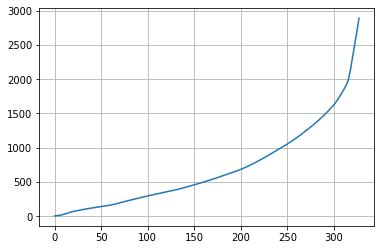

In [1087]:
cum_errors = np.sqrt(((df_validation.sort_values("diff")["diff"] ** 2).cumsum() / (np.arange(len(df_validation)) + 1)))
plt.plot(cum_errors.values)
plt.grid()

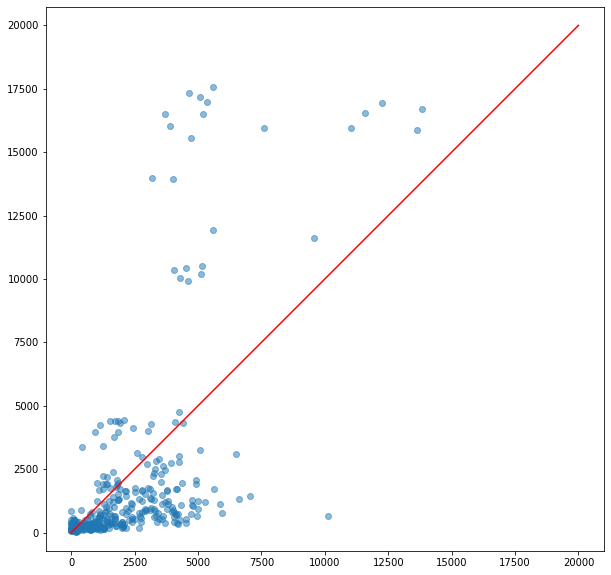

In [1088]:
plt.figure(figsize=(10, 10))
plt.scatter(y_predicted, y_val, alpha=0.5)
plt.plot([0, 20_000], [0, 20_000], color="red")
plt.axis("equal");

In [1095]:
model

LGBMRegressor(colsample_bytree=0.6, extra_trees=True, learning_rate=0.02,
              max_depth=3, n_estimators=300, num_leaves=7, objective='mse',
              verbosity=-1)

<BarContainer object of 94 artists>

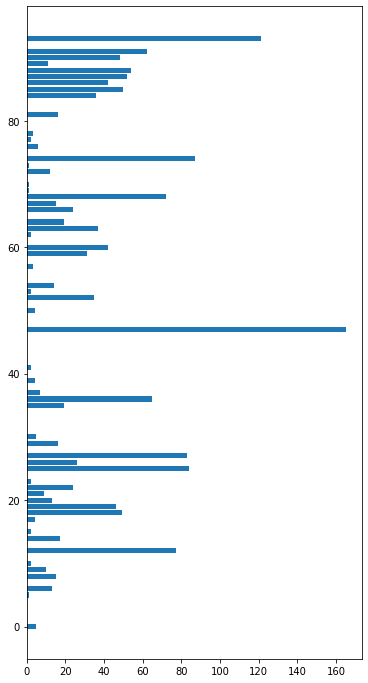

In [1093]:
plt.figure(figsize=(6, 12))
plt.barh(
    np.arange(len(model.feature_importances_))[::-1],
    model.feature_importances_
)

In [1090]:
n_features = 20

feature_importances = model.feature_importances_
most_important_feature_indices = feature_importances.argsort()[-n_features:]
feature_names = np.asarray(
    encoder.get_feature_names(input_features=categorical_features).tolist()
    + numerical_features
    + name_vectorizer.get_feature_names()
)

plt.figure(figsize=(6, 12))
plt.barh(
    np.arange(n_features),
    feature_importances[most_important_feature_indices],
)
plt.yticks(
    np.arange(n_features),
    feature_names[most_important_feature_indices]
);

TypeError: get_feature_names() got an unexpected keyword argument 'input_features'

In [1091]:
df_validation["sales_predicted"] = y_predicted.round()
df_validation.groupby("year_week").agg({"sales_predicted": sum, "sales": sum})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,sales_predicted,sales
year_week,,
201937,86142.0,79013
201938,98715.0,79539
201939,102760.0,79919
201940,103654.0,81194
201941,90668.0,82899
201942,92012.0,81562
201943,88814.0,81651
201944,95876.0,80493


# Make one prediction per each week

In [891]:
from tqdm.notebook import tqdm

embeddings_dict = {}
with open("../data/glove.6B.200d.txt", 'r', encoding="utf-8") as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [752]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [753]:
df_train.description[df_train.description.str.len() < 5]

775    TK
776    TK
Name: description, dtype: object

In [803]:
from nltk.tokenize import sent_tokenize, word_tokenize 

vectors_desc_train = []
for desc in tqdm(df_train.recipe_name_clean.str.strip().str.lower()):
    if not pd.isnull(desc):
        tokens = word_tokenize(desc)
        vectors = [embeddings_dict[t] for t in tokens if t in embeddings_dict]
        if len(vectors) == 0:
            vector = np.zeros(50)
        else:
            vector = sum(vectors) / len(vectors)
    else:
        vector = np.zeros(50)
    vectors_desc_train.append(vector)

In [804]:
from nltk.tokenize import sent_tokenize, word_tokenize 

vectors_desc_val = []
for desc in tqdm(df_validation.recipe_name_clean.str.strip().str.lower()):
    if not pd.isnull(desc):
        tokens = word_tokenize(desc)
        vectors = [embeddings_dict[t] for t in tokens if t in embeddings_dict]
        if len(vectors) == 0:
            vector = np.zeros(50)
        else:
            vector = sum(vectors) / len(vectors)
    else:
        vector = np.zeros(50)
    vectors_desc_val.append(vector)

In [848]:
vec = np.array(vectors_desc_train)
# vec /= np.linalg.norm(vec, axis=1).reshape(-1, 1)
print(vec.shape)
vec

(2291, 50)


array([[ 0.16673334, -0.14837001, -0.84104663, ..., -0.70449328,
        -0.12239199,  0.58960003],
       [ 0.59495902, -0.55285668, -1.11698329, ..., -0.13754   ,
        -0.03849524,  0.21392733],
       [-0.44107825, -0.47613749, -0.36648256, ...,  0.12728176,
         0.5830425 , -0.15604   ],
       ...,
       [ 0.04070767, -0.71649903, -0.60144997, ..., -0.13651334,
        -0.19261734,  0.09067133],
       [-0.11531   , -0.52096999, -0.24787   , ..., -0.43349001,
        -0.40147001,  0.13765   ],
       [ 0.04070767, -0.71649903, -0.60144997, ..., -0.13651334,
        -0.19261734,  0.09067133]])

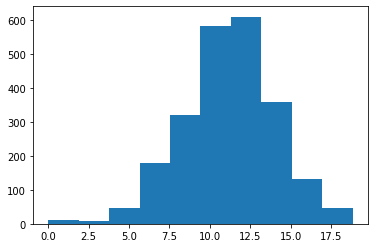

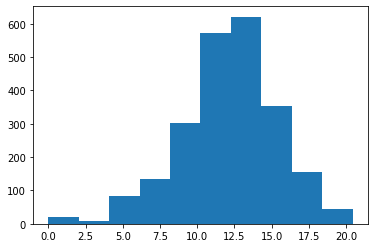

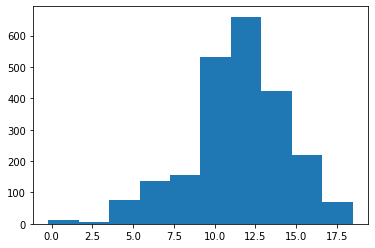

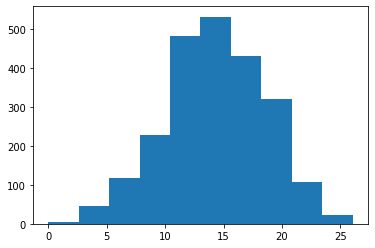

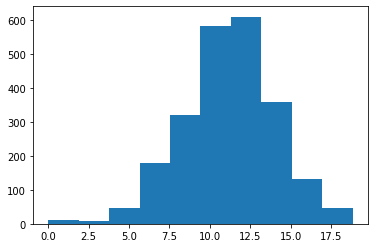

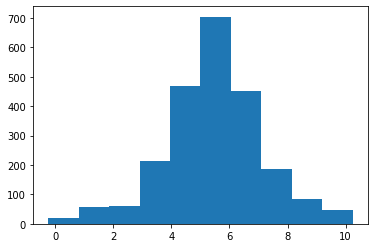

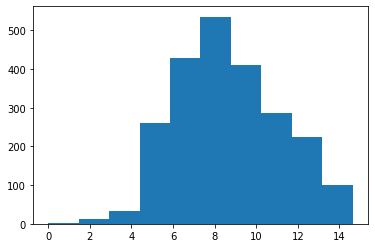

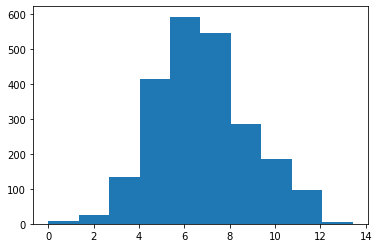

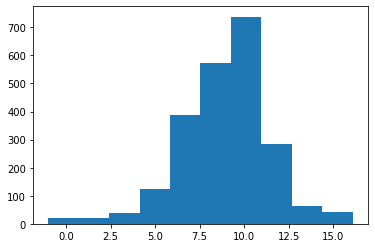

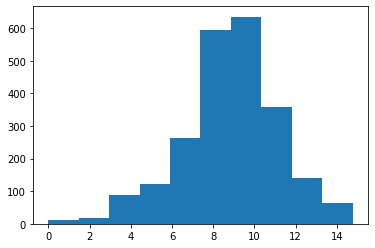

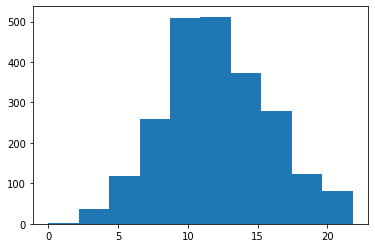

In [849]:
for i, row in enumerate(vec.dot(vec.T)[100:]):
    plt.hist(row)
    plt.show()
    
    if i >= 10:
        break

In [184]:
desc

'TK'

In [826]:
data

,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,description,difficulty,dish_type,heat_level,fat,is_classic,number_of_ingredients_per_recipe,preferences,carbs_content,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales,recipe_name_clean,week_day,close_to_new_year,n_words,month,count,total_sales,cumcount
829,201829,16768,AFC Miso-Tamari ...,z_amazon,809.0,NaN,NaN,NaN,These are far fr...,easy,meat,NaN,NaN,No,10,beef,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,afc miso-tamari ...,2018-07-16,0,400,7,26,77671,18.0
834,201829,16769,AFC Chicken in P...,z_amazon,763.0,NaN,NaN,NaN,This Chinese tak...,easy,meat,NaN,NaN,No,9,poultry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,afc chicken in p...,2018-07-16,0,459,7,26,77671,16.0
835,201829,16770,AFC Tamale Pie,z_amazon,848.0,NaN,NaN,NaN,This dish is you...,easy,meat,NaN,NaN,No,10,beef,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,afc tamale pie,2018-07-16,0,355,7,26,77671,22.0
836,201829,16767,AFC Fried Chicke...,z_amazon,1130.0,NaN,NaN,NaN,Son of a biscuit...,easy,meat,NaN,NaN,No,9,poultry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,afc fried chicke...,2018-07-16,0,409,7,26,77671,26.0
837,201829,16771,AFC Salsa Verde ...,z_amazon,666.0,NaN,NaN,NaN,Our green enchil...,easy,veggie,NaN,NaN,No,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,afc salsa verde ...,2018-07-16,0,429,7,26,77671,8.0
838,201829,16766,AFC Cheese Ravio...,z_amazon,840.0,NaN,NaN,NaN,This dish is a t...,easy,veggie,NaN,NaN,No,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,afc cheese ravio...,2018-07-16,0,409,7,26,77671,21.0


In [ ]:
data

In [895]:
def make_vector(desc):
    if not pd.isnull(desc):
        tokens = word_tokenize(desc)
        vectors = [embeddings_dict[t] for t in tokens if t in embeddings_dict]
        if len(vectors) == 0:
            vector = np.zeros(200)
        else:
            vector = sum(vectors) / len(vectors)
    else:
        vector = np.zeros(200)
    return vector

make_vector("chilli and paper")[:5]

array([-0.12688   ,  0.4655633 , -0.08597567,  0.24254365, -0.033701  ],
      dtype=float32)

In [898]:
uniquenesses = []
all_sales = []
for (product_type, year_week), data in tqdm(df_train.groupby(["product_type", "year_week"])):
#     print(product_type, year_week)
    vectors = np.vstack(data.recipe_name_clean.apply(make_vector).values)
    vectors /= np.linalg.norm(vectors, axis=1).reshape(-1, 1)
    similarities = vectors.dot(vectors.T)
    uniqueness = np.percentile(similarities, [20], axis=1)[0]
    
    uniquenesses.append(uniqueness)
    all_sales.append(data.sales.values)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


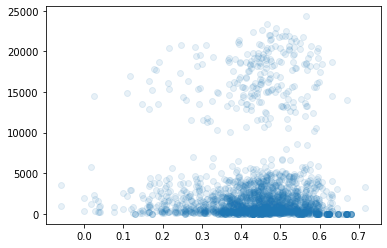

In [899]:
plt.scatter(np.concatenate(uniquenesses), np.concatenate(all_sales), alpha=0.1)